<a href="https://colab.research.google.com/github/surya-1729/ct_reconstruct_collab/blob/main/CT_Reconstructio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:

import torch
import torch.nn as nn
import torch.functional as F
import torchvision.datasets as dset
from torch.utils.data import Dataset, DataLoader
import numpy as np
from skimage.transform import radon,rescale,resize

#import torchvision.transforms as transforms

input_traindata = dset.MNIST( root="/content/Mnist", train = True, transform = None,download= True) #Downloading data

ny,nx = input_traindata.data[0].shape #storing image shape matrix in nx,ny
input_traindata = input_traindata.data  # taking images


In [7]:



def getRadonMatrix(theta,ny,nx):
    colum_of_A = radon(np.zeros((ny,nx)), theta=theta)  #  this is just to know the size of this
    A = np.zeros((colum_of_A.size,nx*ny))
    for i in range(ny):
        for j in range(nx):
            basis_vec = np.zeros((ny,nx))
            basis_vec[i,j] = 1
            colum_of_A = radon(basis_vec, theta=theta)
            A[:,j+i*nx] = np.reshape(colum_of_A, colum_of_A.size)
            
    return A

In [8]:
class SinogramDataset(Dataset):
    def __init__(self,image_data,A,theta,noise_level,):  #Custom dataset taking Imagedataset ,theta,noise_level and genrate a dataset
        self.image_data =image_data
        self.noise_level = noise_level
        self.A = A
        self.theta =theta
    def __len__(self):
        return len(self.image_data)

    def __getitem__(self,idx):
        label = self.image_data[idx].double()/255
        ny,nx = self.image_data[idx].shape
        vec_img = torch.reshape(self.image_data[idx],(1,ny*nx)).double()/255# genearating Vec_image
        sinogram = vec_img@self.A.T
        #sinogram = torch.reshape(, (len(theta),ny)) # genarating Vec_sinogram_image from radonmatrix and reshaping into 2d 
        sinogram_noisy = sinogram + self.noise_level*torch.randn(sinogram.shape) #Adding Noise to the image 
        return sinogram_noisy,label

In [9]:
theta = np.linspace(0.,180.,26, endpoint=False)  # theta values
A = torch.from_numpy(getRadonMatrix(theta,ny,nx))  # generating A matrix 
trainset =SinogramDataset(input_traindata,A,theta,0.1) # genarating a train_dataset
print(A.shape)
pseudo_inverse_of_A = torch.from_numpy(np.linalg.pinv(A))
print(pseudo_inverse_of_A.shape)

/usr/local/lib/python3.7/dist-packages/skimage/transform/radon_transform.py:83: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


torch.Size([728, 784])
torch.Size([784, 728])


torch.Size([1, 728])


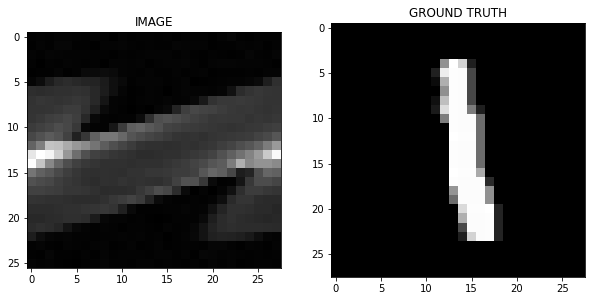

In [10]:
sinogram_noisy, label = trainset[6]
print(sinogram_noisy.shape)
import matplotlib.pyplot as plt

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(torch.reshape(sinogram_noisy,(len(theta),ny)),cmap ='gray')

ax2.set_title('GROUND TRUTH')
ax2.imshow(label,cmap = 'gray')

In [ ]:
trainloader = DataLoader(trainset, batch_size=60, shuffle=True)
batch_size=60


In [ ]:
class PrimalDualNetwork(nn.Module):
    def __init__(self):
        super(PrimalDualNetwork,self).__init__()
        hidden = 4
#        self.fc1 = nn.Linear(A.size()[1], hidden)
        self.conv1image = nn.Conv2d(1, hidden, 3, padding=1)
        self.conv2image = nn.Conv2d(hidden,1, 3, padding=1)
        self.conv1sino = nn.Conv2d(1, hidden, 3, padding=1)
        self.conv2sino = nn.Conv2d(hidden,1, 3, padding=1)
#        self.fc2 = nn.Linear(hidden, A.size()[1])
        
        
    def forward(self, sinogram,inv_A,maxiter,tau,A):   
        # A needs to be of dimension: (sinogram_dimension x image_pixels)
        # sinogram will be of dimension: (number_of_examples (batchsize)  x  sinogram_dimension)
        output =  sinogram @ inv_A.T

        for i in range(maxiter):
            # possible here: Design a small sinogramCNN on err!
            err = (output@A.T - sinogram)
            err = torch.reshape(err,(batch_size,1,len(theta),ny))
            err = self.conv2sino(nn.functional.relu(self.conv1sino(err)))

            intermediateOutput = output - tau * err@A
            output = self.conv2image(nn.functional.relu(self.conv1image(intermediateOutput)))
            # in the above notation imageSpaceCNN = self.conv2(nn.functional.relu(self.conv1( * )))
            
        return output 
        

# New Section

In [ ]:
def train_fn(data_loader, model, optimizer):
  model.train()
  criterion = nn.MSELoss()

  for i,ele in enumerate(trainloader):
      batch_input,batch_output = ele
      prediction = model(batch_input,pseudo_inverse_of_A,5,0.01,A)
      optimizer.zero_grad()
      loss = criterion(prediction, batch_output)
      loss.backward()
      optimizer.step()
      
  return loss

In [ ]:
model = PrimalDualNetwork()

optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

number_of_epochs = 10
for epoch in range(number_of_epochs):
  train_loss = train_fn(trainloader, model, optimizer)
  
    
  if epoch%1==0:
    print(f"Epoch :{epoch+1} Train_loss : {train_loss}" )

RuntimeError: ignored

In [ ]:
import matplotlib.pyplot as plt

for index,data in enumerate(trainloader):
  sinogram,image = data
  print(sinogram.size())
  print(image.size())
  break

torch.Size([60, 26, 28])
torch.Size([60, 28, 28])
